# Topic 19: Multiple Linear Regression

- onl01-dtsc-ft-022221
- 04/08/21

## Resources:

- **[OSEMN Data Science Workflow Notebook](https://github.com/jirvingphd/fsds-osemn-workflow)**
    - `student_OSEMN.ipynb`: also included in notes repo

## LEARNING OBJECTIVES

- Learn how to expand our last lesson to include multiple independent variables.
- Learn ways to deal with categorical variables.
- Learn about multicollinearity of features
- Learn about how to improve a baseline model based on results
- Learn how to run a multiple regression using statsmodels

<!-- ### TOPICS:

#### Part 1 
- Multiple Linear Regression
- Dealing with Categorical Variables
- Multicollinearity of Features
- Multiple Linear Regression in Statsmodels

#### Part 2
- Feature Scaling & Normalization
- Model Fit and Validation/Cross Validation -->

## Questions?



- 

# Revisiting Our  Simple Linear Regression  Modeling with Movies

### PREVIOUSLY ON... Topic 18

- We discussed the assumptions for a linear regression:
    - Linear relationship between predictor and target variable.
    - Predictor (x) and its error terms have a normal distribution
    - Homoskedasticity ( variance of residuals is constant)
    
- We learned how to run a single regession in statsmodels

## Imports & Loading Data

In [5]:
## Importing our study group functions
%load_ext autoreload
%autoreload 2
import sys
    
py_folder = "../../../py_files/" # CHANGE TO REFECT YOUR NOTEBOOKS LOCATION COMPARED TO THE PY_FILES FOLDER
sys.path.append(py_folder)
import functions_SG as sg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from scipy import stats

In [8]:
plt.style.use('seaborn-notebook')
# plt.rcParams['figure.figsize'] = [10,6]
pd.set_option('display.float_format', lambda x: f"{x:,}")
pd.set_option('display.max_columns',0)

In [9]:
### NEW MOVIE DATASET

def load_movie_data(verbose=True,include_genre=False):
    ## Thanks to Johnny Dryma for letting us use his data
    movie_data_url = "https://raw.githubusercontent.com/Drymander/dsc-phase-1-project/master/data/2012-2019%20FULL.csv"
    dfm = pd.read_csv(movie_data_url,index_col=0,parse_dates=['release_date'])

    ## List of cols that need processsing before use
    # cols_need_processing=['genres','production_companies',
    #                       'belongs_to_collection']

    ## Save only the columns of interest
    df = dfm[['id','imdb_id','original_title','title','genres','mpaa_rating',
         'release_date','runtime','budget','revenue',
         'vote_count','vote_average','popularity','adult','original_language']].copy()

    ## Keep only movies with financial data
    df=df[(df['budget']>0) & (df['revenue']>0)]

    if include_genre==True:
        df['genre_list'] = df['genres'].map(lambda x: eval(x))
        df['genre_list'] = df['genre_list'].map(lambda x: [g['name'] for g in x])
    else:
        ## Dropping genres isntead
        df.drop(columns=['genres'],inplace=True)
        
    ## Feature Engineering
    # df['profit'] = df['revenue'] - df['budget']
    # df['ROI'] = df['profit']/df['budget']

    ## Removing Extreme values for class purposes
    # df=df[df['ROI']<1000]

    ## Drop nulls & reset index
    df.dropna(inplace=True)
    df.set_index('id',inplace=True)

    if verbose:
        display(df.head(),df.info())
    return df

df = load_movie_data()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 24428 to 630331
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            1300 non-null   object        
 1   original_title     1300 non-null   object        
 2   title              1300 non-null   object        
 3   mpaa_rating        1300 non-null   object        
 4   release_date       1300 non-null   datetime64[ns]
 5   runtime            1300 non-null   float64       
 6   budget             1300 non-null   int64         
 7   revenue            1300 non-null   int64         
 8   vote_count         1300 non-null   int64         
 9   vote_average       1300 non-null   float64       
 10  popularity         1300 non-null   float64       
 11  adult              1300 non-null   bool          
 12  original_language  1300 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), obje

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG-13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG-13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,PG,2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,PG-13,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en


None

## Simple Linear Regression Regression

In [10]:
## Scatter Plots for Linearity Check
def plot_data(X='budget',y='revenue',data=df,fit_reg=False):
    priceFmt = mpl.ticker.StrMethodFormatter("${x:,.0f}")
    ax = sns.regplot(x=X,y=y,data=data,fit_reg=fit_reg)
    ax.yaxis.set_major_formatter(priceFmt)
    fig=ax.get_figure()
    return fig,ax

>- Use one $X$ variable to predict $y$

 $$y=mx+b$$

 $$y = \beta_1 x_1 + \beta_0 $$

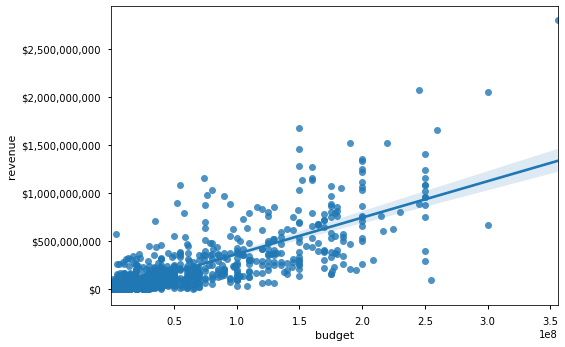

In [11]:
plot_data(X='budget',y='revenue',data=df,fit_reg=True);

### Our Baseline Simple Linear Regression

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     2127.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):          9.19e-276
Time:                        13:48:18   Log-Likelihood:                -26440.
No. Observations:                1300   AIC:                         5.288e+04
Df Residuals:                    1298   BIC:                         5.289e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.858e+07   5.93e+06     -3.136      0.002   -3.02e+07   -6.96e+06
budget         3.7903      0.082     46.120      0.000       3.629       3.951
==============================================================================
Omnibus:                      708.628   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12328.555
Skew:                           2.134   Prob(JB):                         0.00
Kurtosis:                      17.470   Cond. No.                     9.35e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

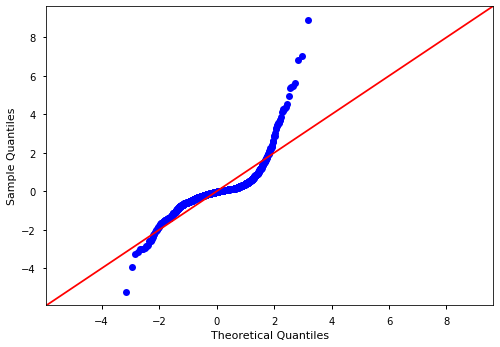

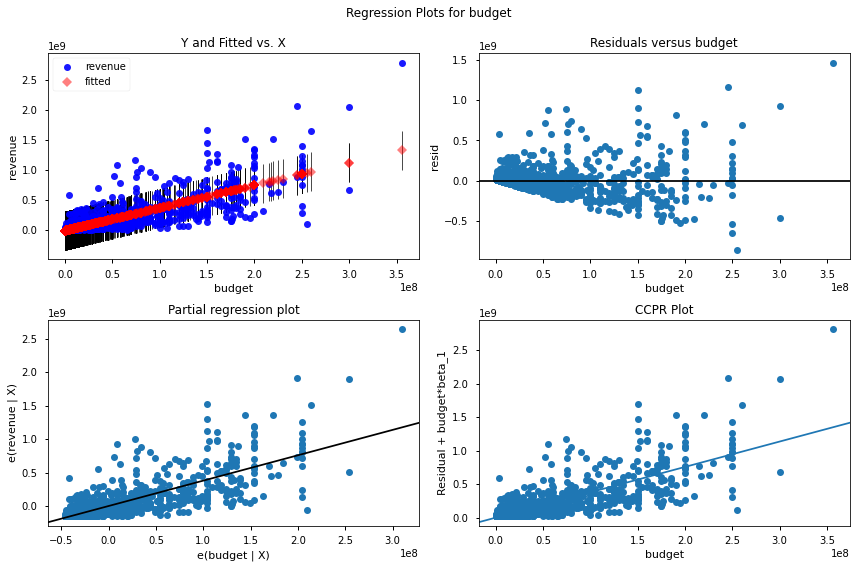

In [12]:
f = "revenue~budget"
model1 = smf.ols(f,df).fit()
display(model1.summary())

fig = sm.graphics.qqplot(model1.resid,dist=stats.norm,fit=True,line='45')
fig = sm.graphics.plot_regress_exog(model1, "budget", fig=plt.figure(figsize=(12,8)))

### Our Second Model After Removing Outliers

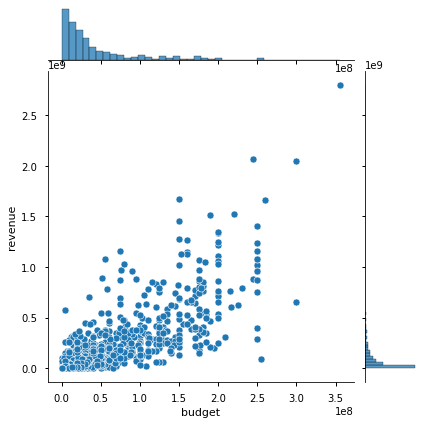

In [13]:
## Visualize Data WITH outliers
sns.jointplot(data=df,x='budget',y='revenue')

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
70981,tt1446714,Prometheus,Prometheus,R,2012-05-30,124.0,130000000,403170142,9183,6.5,46.651,False,en


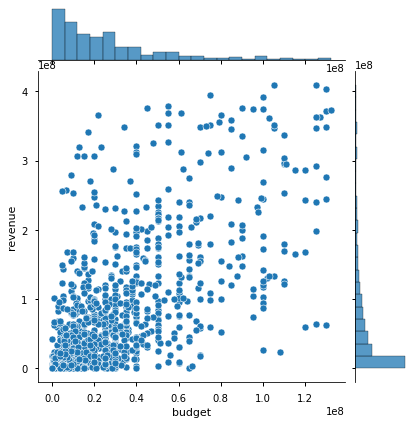

In [14]:
## Get X outliers
X_outliers_IQR = sg.find_outliers_IQR(df['budget'])
y_outliers_IQR = sg.find_outliers_IQR(df['revenue'])

## Combine outliers
idx_outliers_IQR = X_outliers_IQR  | y_outliers_IQR
idx_outliers_IQR.sum()


## Create df_clean
df_clean = df[~idx_outliers_IQR].copy()
sns.jointplot(data=df_clean,x='budget',y='revenue')

df_clean.head(2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     881.0
Date:                Thu, 08 Apr 2021   Prob (F-statistic):          1.98e-143
Time:                        13:48:20   Log-Likelihood:                -21900.
No. Observations:                1126   AIC:                         4.380e+04
Df Residuals:                    1124   BIC:                         4.381e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.332e+07   2.86e+06      4.649      0.000     7.7e+06    1.89e+07
budget         2.1166      0.071     29.682      0.000       1.977       2.257
==============================================================================
Omnibus:                      290.848   Durbin-Watson:                   1.675
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              825.435
Skew:                           1.306   Prob(JB):                    5.74e-180
Kurtosis:                       6.282   Cond. No.                     5.70e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.7e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

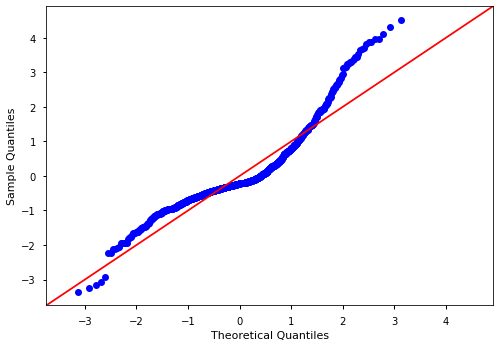

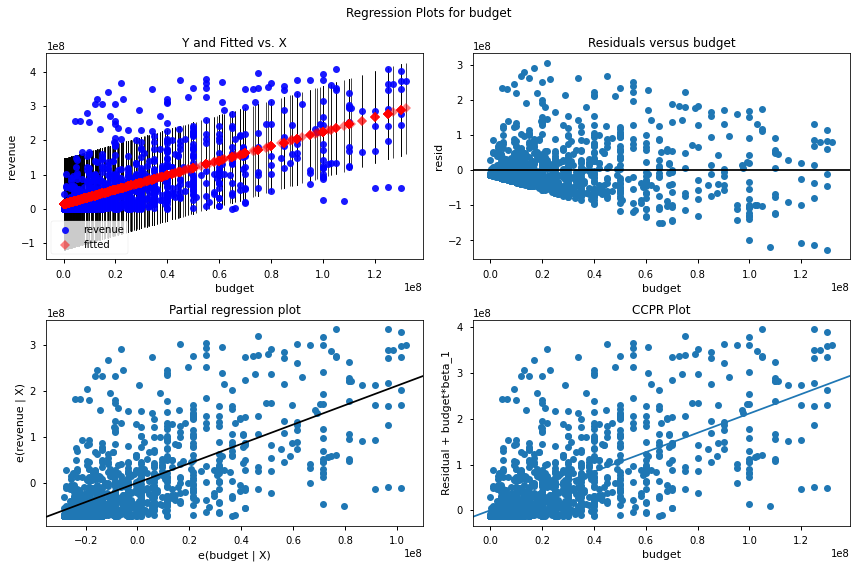

In [15]:
## Get the model params 
f = "revenue~budget"
model = smf.ols(f,df_clean).fit()
display(model.summary())
sm.graphics.qqplot(model.resid,dist=stats.norm,line='45',fit=True);
sm.graphics.plot_regress_exog(model,'budget',plt.figure(figsize=(12,8)));

# Multiple Linear Regression

### Today's Objectives

- Briefly discuss big-picture re: multiple linear regressions vs simple linear regressions.
- Discuss ways to handle categorical data.
- Discuss a fourth assumption with Multiple Regression - Assumption of No Multicollinearity
- Extend yesterday's task to use multiple features from the movie dataset. 

## Multiple Predictor (X) Variables

$$ y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 +\ldots + \beta_n x_n $$

<img src="https://raw.githubusercontent.com/learn-co-students/dsc-multiple-linear-regression-online-ds-ft-100719/master/images/multiple_reg.png" width=400>

#### $\hat Y$ vs $Y$


- Y: Actual value corresponding to a specific X value

- "Y hat" ($\hat Y$): Predicted value predicted fromn a specific X value.


$$ \hat y = \hat\beta_0 + \hat\beta_1 x_1 + \hat\beta_2 x_2 +\ldots + \hat\beta_n x_n $$ 

where $n$ is the number of predictors, $\beta_0$ is the intercept, and $\hat y$ is the so-called "fitted line" or the predicted value associated with the dependent variable.

## DEALING WITH CATEGORICAL VARIABLES

- What are categorical variables?
- Understand creating dummy variables for predictors.
- Use pandas and Scikit-Learn to create dumies
- Understand and avoid the "dummy variable trap"

### What are categorical variables?
- Variables that do not represent a continuous/ordinal number. 

### Identifying categorical variables:
What to look for?
1. Column dtype is 'object'
2. Use `df.describe()` -  check for min/max. Are they integers?
3. Use scatterplots & histograms -  look for columns of datapoints

In [16]:
## Check dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 24428 to 630331
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            1300 non-null   object        
 1   original_title     1300 non-null   object        
 2   title              1300 non-null   object        
 3   mpaa_rating        1300 non-null   object        
 4   release_date       1300 non-null   datetime64[ns]
 5   runtime            1300 non-null   float64       
 6   budget             1300 non-null   int64         
 7   revenue            1300 non-null   int64         
 8   vote_count         1300 non-null   int64         
 9   vote_average       1300 non-null   float64       
 10  popularity         1300 non-null   float64       
 11  adult              1300 non-null   bool          
 12  original_language  1300 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), obje

In [17]:
## Can use select_dtypes
cat_cols = list(df.select_dtypes('O').columns)
cat_cols

['imdb_id', 'original_title', 'title', 'mpaa_rating', 'original_language']

In [18]:
## can do the same for numeric
num_cols =list(df.select_dtypes('number').columns)
num_cols

['runtime', 'budget', 'revenue', 'vote_count', 'vote_average', 'popularity']

In [19]:
## Check describe
df.describe()

,runtime,budget,revenue,vote_count,vote_average,popularity
count,"1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0"
mean,109.34153846153846,"45,900,017.192307696","155,390,520.90076923","3,048.479230769231",6.407538461538461,34.06769615384615
std,16.982950217591988,"55,641,755.675761335","267,617,277.28683838","3,757.7980193390854",0.940552522610109,37.70137389978608
min,78.0,10.0,1.0,0.0,0.0,0.6
25%,96.0,"10,000,000.0","10,276,110.0",602.0,5.9,14.20425
50%,107.0,"25,000,000.0","52,410,264.5","1,638.5",6.4,22.548499999999997
75%,119.0,"58,850,000.0","170,262,729.25","4,059.5",7.0,38.3885
max,188.0,"356,000,000.0","2,797,800,564.0","25,296.0",9.0,397.25699999999995


In [20]:
df[num_cols]

,runtime,budget,revenue,vote_count,vote_average,popularity
id,,,,,,
24428,143.0,220000000,1518815515,24252,7.7,151.095
50620,115.0,120000000,829000000,6978,6.5,73.226
82690,101.0,165000000,471222889,9690,7.3,70.21300000000001
57214,88.0,12000000,100000000,4399,6.7,67.687
49051,169.0,250000000,1021103568,14539,7.3,61.052
...,...,...,...,...,...,...
403300,174.0,9000000,4612788,370,7.2,15.434000000000001
520900,119.0,15600000,11620337,211,6.7,15.075999999999999
616584,92.0,50000,359377,171,7.6,14.822000000000001


In [21]:
df.isna().sum()

imdb_id              0
original_title       0
title                0
mpaa_rating          0
release_date         0
runtime              0
budget               0
revenue              0
vote_count           0
vote_average         0
popularity           0
adult                0
original_language    0
dtype: int64

In [22]:
## Inspect the Value Counts for Each Str Col
for col in cat_cols:
    display(df[col].value_counts(dropna=False).sort_index())
    print()

tt0249516    1
tt0337692    1
tt0359950    1
tt0365907    1
tt0369610    1
            ..
tt8772262    1
tt8946378    1
tt9134216    1
tt9285882    1
tt9735328    1
Name: imdb_id, Length: 1300, dtype: int64

'71                                          1
10 Cloverfield Lane                          1
12 Strong                                    1
12 Years a Slave                             1
13 Hours: The Secret Soldiers of Benghazi    1
                                            ..
Zoolander 2                                  1
Zootopia                                     1
mother!                                      1
xXx: Return of Xander Cage                   1
新兵正传                                         1
Name: original_title, Length: 1300, dtype: int64

'71                                          1
10 Cloverfield Lane                          1
12 Strong                                    1
12 Years a Slave                             1
13 Hours: The Secret Soldiers of Benghazi    1
                                            ..
Zombieland: Double Tap                       1
Zoolander 2                                  1
Zootopia                                     1
mother!                                      1
xXx: Return of Xander Cage                   1
Name: title, Length: 1300, dtype: int64

G          9
NC-17      1
NR        22
PG       173
PG-13    498
R        597
Name: mpaa_rating, dtype: int64

en    1300
Name: original_language, dtype: int64

### Transforming Categorical Variables

To use categorical variables for regression, they must be transformed.
There are 2 methods to dealing with them:
1. ~~Label Encoding~~ (not intended for X data!)
    - Replace string categories with integer values (0 to n)
    - Can be done with:
        1. Pandas 
        2. Scikit Learn
        

2. One-hot / dummy encoding
    - Turn each category in a categorical variable into its own variable, that is either a 0 or 1. 0 for rows that do not belong to that sub-category. 1 for rows that belong to the sub-category
    - Can be done with:
        1. Pandas
        2. Scikit Learn


### Label Encoding

In [23]:
## Check the Value Counts for our test column - "BldgType"
df['mpaa_rating'].value_counts(normalize=True)

R          0.4592307692307692
PG-13      0.3830769230769231
PG        0.13307692307692306
NR       0.016923076923076923
G        0.006923076923076923
NC-17   0.0007692307692307692
Name: mpaa_rating, dtype: float64

#### Via pandas.cat.codes

In [24]:
## Label Encode with .cat.codesd
df['mpaa_rating'] = df['mpaa_rating'].astype('category')
df['mpaa_rating'].cat.codes.value_counts(normalize=True)

5      0.4592307692307692
4      0.3830769230769231
3     0.13307692307692306
2    0.016923076923076923
0    0.006923076923076923
1   0.0007692307692307692
dtype: float64

#### Via Sklearn's LabelEncoder

In [25]:
## Using sklearn LabelEncoder
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
rating_enc = encoder.fit_transform(df['mpaa_rating'])
rating_enc

array([4, 4, 3, ..., 5, 5, 2])

In [26]:
encoder.inverse_transform(rating_enc)

array(['PG-13', 'PG-13', 'PG', ..., 'R', 'R', 'NR'], dtype=object)

### Dummy Encoding / One-Hot Encoding

#### Via Pandas.get_dummies()

In [27]:
df['mpaa_rating'].unique()

['PG-13', 'PG', 'R', 'NR', 'G', 'NC-17']
Categories (6, object): ['PG-13', 'PG', 'R', 'NR', 'G', 'NC-17']

In [28]:
# df_dummies = pd.get_dummies(df,columns=['mpaa_rating'])
df_dummies = pd.get_dummies(df['mpaa_rating'])

df_dummies

,G,NC-17,NR,PG,PG-13,R
id,,,,,,
24428,0,0,0,0,1,0
50620,0,0,0,0,1,0
82690,0,0,0,1,0,0
57214,0,0,0,0,0,1
49051,0,0,0,0,1,0
...,...,...,...,...,...,...
403300,0,0,0,0,1,0
520900,0,0,0,1,0,0
616584,0,0,0,0,0,1


#### Via Scikit-Learn's OneHotEncoder

In [29]:
cat_cols = ['mpaa_rating']

In [30]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first',sparse=False)
ohe_vars = encoder.fit_transform(df[cat_cols])
ohe_vars
# pd.DataFrame(ohe_vars,columns=binarizer.classes_)

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [31]:
cat_vars = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(cat_cols))
cat_vars

,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
1295,0.0,0.0,0.0,1.0,0.0
1296,0.0,0.0,1.0,0.0,0.0
1297,0.0,0.0,0.0,0.0,1.0
1298,0.0,0.0,0.0,0.0,1.0


### The Dummy Variable Trap


In [32]:
pd.get_dummies(df['mpaa_rating'],drop_first=True)#,prefix="ohe")

,NC-17,NR,PG,PG-13,R
id,,,,,
24428,0,0,0,1,0
50620,0,0,0,1,0
82690,0,0,1,0,0
57214,0,0,0,0,1
49051,0,0,0,1,0
...,...,...,...,...,...
403300,0,0,0,1,0
520900,0,0,1,0,0
616584,0,0,0,0,1


# Activity: Multiple Linear Regression with Movies

In [33]:
df = load_movie_data(verbose=False)
df.head(2)

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG-13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG-13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 24428 to 630331
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   imdb_id            1300 non-null   object        
 1   original_title     1300 non-null   object        
 2   title              1300 non-null   object        
 3   mpaa_rating        1300 non-null   object        
 4   release_date       1300 non-null   datetime64[ns]
 5   runtime            1300 non-null   float64       
 6   budget             1300 non-null   int64         
 7   revenue            1300 non-null   int64         
 8   vote_count         1300 non-null   int64         
 9   vote_average       1300 non-null   float64       
 10  popularity         1300 non-null   float64       
 11  adult              1300 non-null   bool          
 12  original_language  1300 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(3), int64(3), obje

In [35]:
df.isna().sum()

imdb_id              0
original_title       0
title                0
mpaa_rating          0
release_date         0
runtime              0
budget               0
revenue              0
vote_count           0
vote_average         0
popularity           0
adult                0
original_language    0
dtype: int64

In [36]:
df.describe()

,runtime,budget,revenue,vote_count,vote_average,popularity
count,"1,300.0","1,300.0","1,300.0","1,300.0","1,300.0","1,300.0"
mean,109.34153846153846,"45,900,017.192307696","155,390,520.90076923","3,048.479230769231",6.407538461538461,34.06769615384615
std,16.982950217591988,"55,641,755.675761335","267,617,277.28683838","3,757.7980193390854",0.940552522610109,37.70137389978608
min,78.0,10.0,1.0,0.0,0.0,0.6
25%,96.0,"10,000,000.0","10,276,110.0",602.0,5.9,14.20425
50%,107.0,"25,000,000.0","52,410,264.5","1,638.5",6.4,22.548499999999997
75%,119.0,"58,850,000.0","170,262,729.25","4,059.5",7.0,38.3885
max,188.0,"356,000,000.0","2,797,800,564.0","25,296.0",9.0,397.25699999999995


## Encode Categorical Data

In [37]:
## Remake final cat cols
cat_cols = ['mpaa_rating']
cat_cols

['mpaa_rating']

In [38]:
## Create encoded vars
encoder = OneHotEncoder(sparse=False,drop='first')
ohe_vars = encoder.fit_transform(df[cat_cols])
ohe_vars

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [39]:
## make encoded vars a df
df_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(cat_cols),
                     index=df.index)
df_ohe

,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
id,,,,,
24428,0.0,0.0,0.0,1.0,0.0
50620,0.0,0.0,0.0,1.0,0.0
82690,0.0,0.0,1.0,0.0,0.0
57214,0.0,0.0,0.0,0.0,1.0
49051,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
403300,0.0,0.0,0.0,1.0,0.0
520900,0.0,0.0,1.0,0.0,0.0
616584,0.0,0.0,0.0,0.0,1.0


In [40]:
## Create df model from original df and df_ohe
df_model = pd.concat([df.drop(columns=cat_cols),df_ohe],axis=1)
df_model

,imdb_id,original_title,title,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
id,,,,,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en,0.0,0.0,0.0,1.0,0.0
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en,0.0,0.0,0.0,1.0,0.0
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en,0.0,0.0,1.0,0.0,0.0
57214,tt1636826,Project X,Project X,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en,0.0,0.0,0.0,0.0,1.0
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,2019-12-11,174.0,9000000,4612788,370,7.2,15.434000000000001,False,en,0.0,0.0,0.0,1.0,0.0
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,2019-11-07,119.0,15600000,11620337,211,6.7,15.075999999999999,False,en,0.0,0.0,1.0,0.0,0.0
616584,tt10521814,K-12,K-12,2019-09-05,92.0,50000,359377,171,7.6,14.822000000000001,False,en,0.0,0.0,0.0,0.0,1.0


In [41]:
## Drop columns we don't want to use in the model
df_model.drop(columns=['title','imdb_id','original_title','release_date'],inplace=True)

## New Assumption: No Multicollinearity

### Multicollinearity
- An additional concern to check for.
- Rule of thumb is if correlation between vars is >0.70 is too high


In [42]:
## Get the correlation matrix for our model_df
corr = df_model.drop('runtime',axis=1).corr()
corr

,budget,revenue,vote_count,vote_average,popularity,adult,mpaa_rating_NC-17,mpaa_rating_NR,mpaa_rating_PG,mpaa_rating_PG-13,mpaa_rating_R
budget,1.0,0.7880541068832383,0.6428319323537048,0.18883263789889407,0.5307313077500067,nan,-0.02140026574549731,-0.09468416463902553,0.18253325207255097,0.2516849446443366,-0.3562248990488199
revenue,0.7880541068832383,1.0,0.7750678894535336,0.2888622414017877,0.5845646098503333,nan,-0.016090746375089244,-0.07415097099981587,0.1648665563089114,0.18489420664510625,-0.2821746710990108
vote_count,0.6428319323537048,0.7750678894535336,1.0,0.4286633361449053,0.5142143811374674,nan,-0.010684182411167347,-0.08750779692975517,-0.019278424055343843,0.17228607416596678,-0.13015625202294653
vote_average,0.18883263789889407,0.2888622414017877,0.4286633361449053,1.0,0.2486782266443005,nan,-0.0031735349944100296,-0.12284111736513079,0.0823706310175757,0.03929088506135783,-0.06632932023652723
popularity,0.5307313077500067,0.5845646098503333,0.5142143811374674,0.2486782266443005,1.0,nan,-0.015867443279407974,-0.07680687664961303,-0.0030889338182932833,0.14284973436907472,-0.11911717468728607
adult,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mpaa_rating_NC-17,-0.02140026574549731,-0.016090746375089244,-0.010684182411167347,-0.0031735349944100296,-0.015867443279407974,nan,1.0,-0.0036403348888838084,-0.010870675153869845,-0.021863662348112444,-0.025568480986005178
mpaa_rating_NR,-0.09468416463902553,-0.07415097099981587,-0.08750779692975517,-0.12284111736513079,-0.07680687664961303,nan,-0.0036403348888838084,1.0,-0.051405194538833084,-0.1033887776451447,-0.12090810557246218
mpaa_rating_PG,0.18253325207255097,0.1648665563089114,-0.019278424055343843,0.0823706310175757,-0.0030889338182932833,nan,-0.010870675153869845,-0.051405194538833084,1.0,-0.30873692960723415,-0.3610526996188209
mpaa_rating_PG-13,0.2516849446443366,0.18489420664510625,0.17228607416596678,0.03929088506135783,0.14284973436907472,nan,-0.021863662348112444,-0.1033887776451447,-0.30873692960723415,1.0,-0.7261678049067961


<AxesSubplot:>

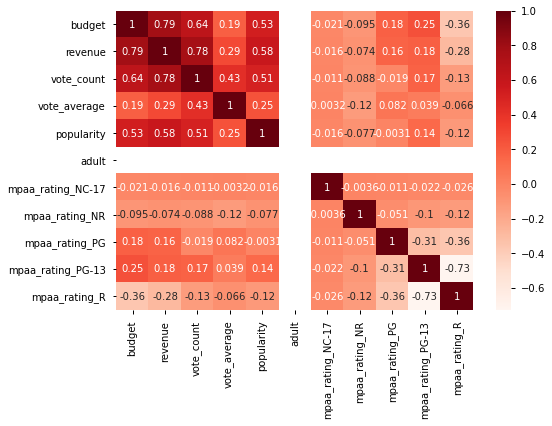

In [43]:
sns.heatmap(corr, annot=True,cmap="Reds")

In [44]:
## Create a mask to make the multiplot easier to look at 
mask = np.zeros_like(corr)
mask

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [45]:
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

<AxesSubplot:>

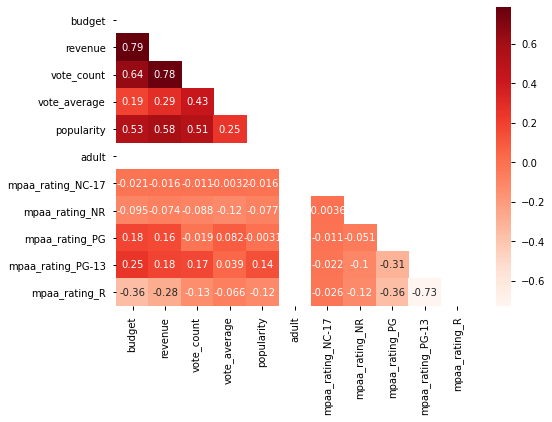

In [46]:
sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

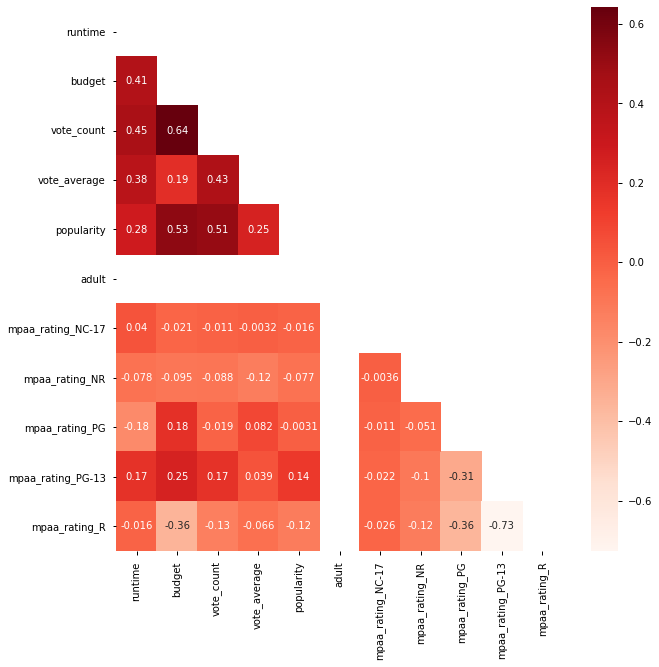

In [47]:
# Checking Visually 

def multiplot(df_model,figsize=(10,10),cmap="Reds"):
    
    corr = df_model.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True,cmap="Reds",mask=mask)
    return fig, ax

multiplot(df_model.drop('revenue',axis=1))

In [48]:
## Drop any multicollinear features
# None

In [49]:
## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_model.drop("revenue",axis=1).columns)
features

'runtime + budget + vote_count + vote_average + popularity + adult + original_language + mpaa_rating_NC-17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG-13 + mpaa_rating_R'

In [50]:
## Create the final formula and create the model
f = "revenue~" + features
print(f)
model = smf.ols(f,df_model).fit()
model.summary()

revenue~runtime + budget + vote_count + vote_average + popularity + adult + original_language + mpaa_rating_NC-17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG-13 + mpaa_rating_R


PatsyError: numbers besides '0' and '1' are only allowed with **
    revenue~runtime + budget + vote_count + vote_average + popularity + adult + original_language + mpaa_rating_NC-17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG-13 + mpaa_rating_R
                                                                                                                   ^^

### Fixing Statsmodels Formulas

In [51]:
df.columns=[col.lower().replace(' ','_') for col in df.columns]
df

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG-13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG-13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,PG,2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,PG-13,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,PG-13,2019-12-11,174.0,9000000,4612788,370,7.2,15.434000000000001,False,en
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,PG,2019-11-07,119.0,15600000,11620337,211,6.7,15.075999999999999,False,en
616584,tt10521814,K-12,K-12,R,2019-09-05,92.0,50000,359377,171,7.6,14.822000000000001,False,en


In [52]:
ratings = df['mpaa_rating'].unique()
rating_dict = {}
for rating in ratings:
    rating_dict[rating] = rating.replace(' ','_').replace('-','_')
rating_dict

{'PG-13': 'PG_13',
 'PG': 'PG',
 'R': 'R',
 'NR': 'NR',
 'G': 'G',
 'NC-17': 'NC_17'}

In [53]:
df['mpaa_rating'] = df['mpaa_rating'].replace(rating_dict)
df

,imdb_id,original_title,title,mpaa_rating,release_date,runtime,budget,revenue,vote_count,vote_average,popularity,adult,original_language
id,,,,,,,,,,,,,
24428,tt0848228,The Avengers,The Avengers,PG_13,2012-04-25,143.0,220000000,1518815515,24252,7.7,151.095,False,en
50620,tt1673434,The Twilight Saga: Breaking Dawn - Part 2,The Twilight Saga: Breaking Dawn - Part 2,PG_13,2012-11-13,115.0,120000000,829000000,6978,6.5,73.226,False,en
82690,tt1772341,Wreck-It Ralph,Wreck-It Ralph,PG,2012-11-01,101.0,165000000,471222889,9690,7.3,70.21300000000001,False,en
57214,tt1636826,Project X,Project X,R,2012-03-01,88.0,12000000,100000000,4399,6.7,67.687,False,en
49051,tt0903624,The Hobbit: An Unexpected Journey,The Hobbit: An Unexpected Journey,PG_13,2012-11-26,169.0,250000000,1021103568,14539,7.3,61.052,False,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
403300,tt5827916,A Hidden Life,A Hidden Life,PG_13,2019-12-11,174.0,9000000,4612788,370,7.2,15.434000000000001,False,en
520900,tt6439020,The Personal History of David Copperfield,The Personal History of David Copperfield,PG,2019-11-07,119.0,15600000,11620337,211,6.7,15.075999999999999,False,en
616584,tt10521814,K-12,K-12,R,2019-09-05,92.0,50000,359377,171,7.6,14.822000000000001,False,en


### Prepare df_model again

In [54]:
## Create encoded vars
encoder = OneHotEncoder(sparse=False,drop='first')
ohe_vars = encoder.fit_transform(df[cat_cols])
## make encoded vars a df
df_ohe = pd.DataFrame(ohe_vars,columns=encoder.get_feature_names(cat_cols),
                     index=df.index)
## Create df model from original df and df_ohe
df_model = pd.concat([df.drop(columns=cat_cols),df_ohe],axis=1)
df_model.drop(columns=['title','imdb_id','original_title','release_date'],inplace=True)

(<Figure size 720x720 with 2 Axes>, <AxesSubplot:>)

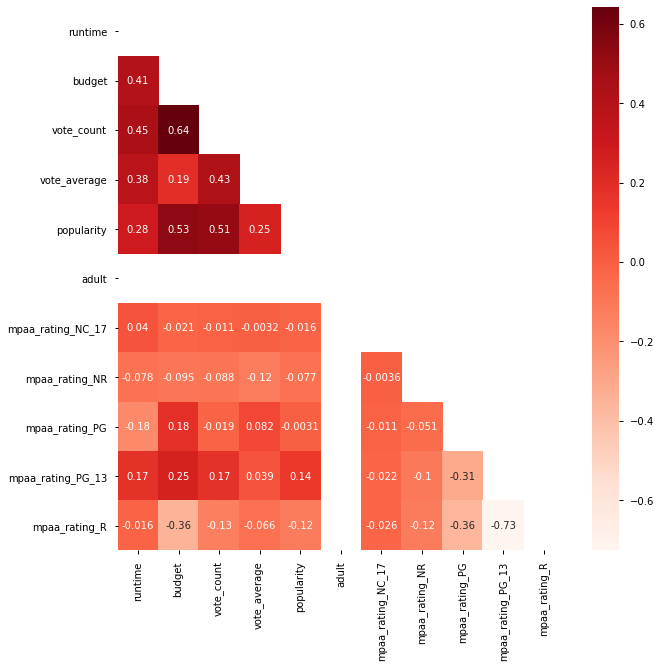

In [55]:
multiplot(df_model.drop('revenue',axis=1))

In [56]:
## Create a string representing the right side of the ~ in our formula
features = ' + '.join(df_model.drop("revenue",axis=1).columns)
features

'runtime + budget + vote_count + vote_average + popularity + adult + original_language + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R'

In [57]:
## Create the final formula and create the model
f = "revenue~" + features
print(f)
model = smf.ols(f,df_model).fit()
model.summary()

revenue~runtime + budget + vote_count + vote_average + popularity + adult + original_language + mpaa_rating_NC_17 + mpaa_rating_NR + mpaa_rating_PG + mpaa_rating_PG_13 + mpaa_rating_R


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     425.6
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        13:48:38   Log-Likelihood:                -26122.
No. Observations:                1300   AIC:                         5.227e+04
Df Residuals:                    1289   BIC:                         5.232e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          1.103e+08   5.38e+07      2.049      0.041    4.68e+06    2.16e+08
adult[T.True]         2.8391      1.385      2.050      0.041       0.123       5.556
runtime           -5.352e+05   2.64e+05     -2.027      0.043   -1.05e+06   -1.71e+04
budget                1.9486      0.103     18.884      0.000       1.746       2.151
vote_count           3.3e+04   1443.482     22.858      0.000    3.02e+04    3.58e+04
vote_average      -4.854e+06   4.58e+06     -1.060      0.290   -1.38e+07    4.13e+06
popularity         1.014e+06   1.18e+05      8.615      0.000    7.83e+05    1.24e+06
mpaa_rating_NC_17 -7.915e+07   1.37e+08     -0.576      0.565   -3.49e+08     1.9e+08
mpaa_rating_NR    -6.745e+07   5.22e+07     -1.291      0.197    -1.7e+08     3.5e+07
mpaa_rating_PG    -2.459e+07   4.44e+07     -0.554      0.580   -1.12e+08    6.25e+07
mpaa_rating_PG_13 -9.351e+07   4.42e+07     -2.116      0.035    -1.8e+08   -6.81e+06
mpaa_rating_R     -1.079e+08   4.45e+07     -2.426      0.015   -1.95e+08   -2.07e+07
==============================================================================
Omnibus:                      849.330   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25908.797
Skew:                           2.547   Prob(JB):                         0.00
Kurtosis:                      24.269   Cond. No.                     1.08e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.8e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

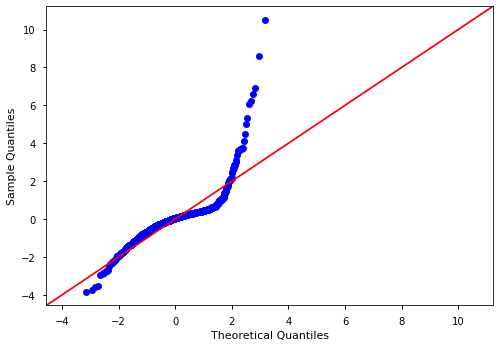

In [58]:
fig = sm.graphics.qqplot(model.resid,dist=stats.norm,fit=True,line='45')

# fig = sm.graphics.plot_regress_exog(model, "", fig=plt.figure(figsize=(12,8)))

## TO DOs

- In today's study group, we did NOT demo the absolute best way to prepare and perform a regression model.

- Additional Topics to discuss tomorrow:
    - train-test-split/cross-validation
    - Using VIF to deal with multicollinearity
    - Using feature selection methods
    - Outlier removal